In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, recall_score, f1_score
from sklearn import metrics

In [52]:
df_cct = pd.read_parquet("/home/onyxia/work/df_all.parquet")

In [54]:
# Pour "Use Chip":

enc = OneHotEncoder(handle_unknown='ignore')

features_array = enc.fit_transform(df_cct[["Use Chip"]]).toarray()

features_labels = np.hstack(np.array(enc.categories_))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

In [56]:
df_cct = df_cct[['day_nbt/last_30d_av_day_nbt', 'daily_amount', 'Amount',
       'amt/daily_income', 'last_3d_amt/nbt', 'Online Transaction',
       'Credit Limit', 'delta_t_s_card', 'hr_nbt/last_30d_av_hr_nbt',
       'delta_t_s', 'Is Fraud?']]

### Correlation map

<Axes: >

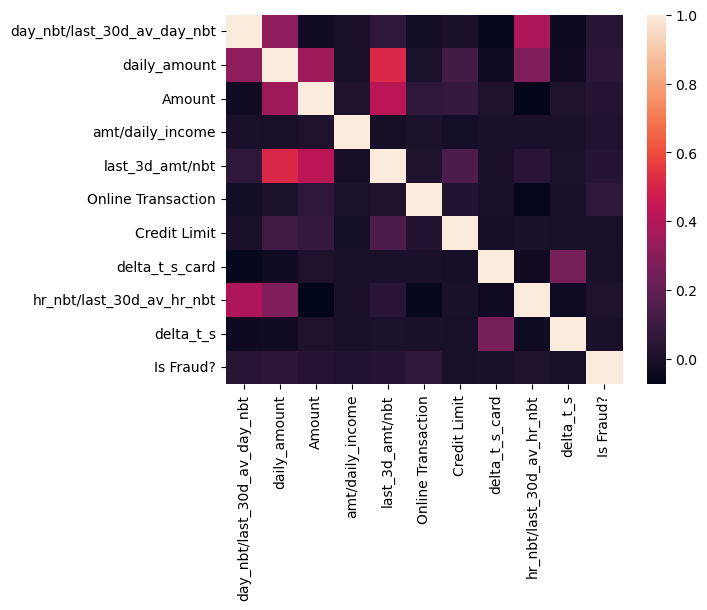

In [57]:
sns.heatmap(df_cct.corr())

### Preprocessing

In [58]:
# selecting features
features = ['day_nbt/last_30d_av_day_nbt', 'daily_amount', 'Amount',
       'amt/daily_income', 'last_3d_amt/nbt', 'Online Transaction',
       'Credit Limit', 'delta_t_s_card', 'hr_nbt/last_30d_av_hr_nbt',
       'delta_t_s']
X = df_cct[features]
y = df_cct["Is Fraud?"]

In [59]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler

# using Column Transformer for RobustScaler (numerical values) and OneHotEncoder (categorical values)
preprocessor = ColumnTransformer(
        remainder='passthrough', #passthough features not listed
        transformers=[
            ('rbscaler', RobustScaler(), ['day_nbt/last_30d_av_day_nbt', 'daily_amount', 'Amount',
       'amt/daily_income', 'last_3d_amt/nbt',
       'Credit Limit', 'delta_t_s_card', 'hr_nbt/last_30d_av_hr_nbt',
       'delta_t_s'])
       ])
X = preprocessor.fit_transform(X)

In [60]:
# splitting train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


### Modeling

In [61]:
# Build and train model
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier()

In [62]:
# Apply model to validation data
y_pred = decision_tree.predict(X_test)

### Evaluating

In [63]:
# Evaluate model
print('Classification metrics: \n', classification_report(y_test, y_pred))

Classification metrics: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   7307089
           1       0.11      0.12      0.11      8981

    accuracy                           1.00   7316070
   macro avg       0.55      0.56      0.56   7316070
weighted avg       1.00      1.00      1.00   7316070



In [64]:
# plot confusion matrix function
import itertools

def plot_confusion_matrix(cm,normalize=False,
                              title='Confusion matrix',
                              cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        classes=['Non-Fraud','Fraud']
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=0)
        plt.yticks(tick_marks, classes)
        
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            # print("Normalized confusion matrix")
        else:
            1  # print('Confusion matrix, without normalization')

        # print(cm)

        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        return ()

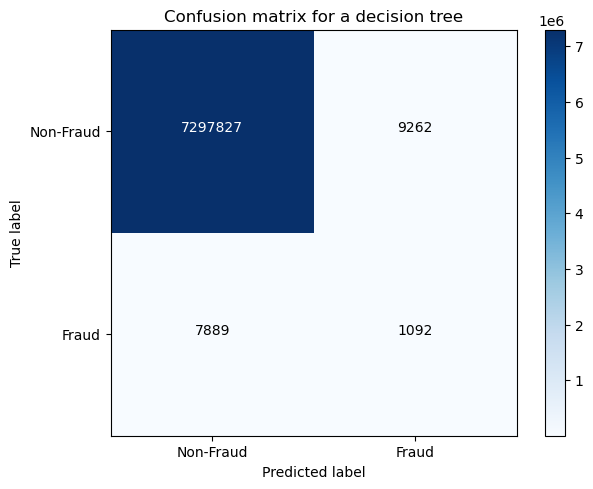

In [65]:

cnf_matrix_dtree = confusion_matrix(y_test, y_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix_dtree, title='Confusion matrix for a decision tree')
plt.show()

In [41]:
from sklearn.metrics import roc_curve, roc_auc_score

In [66]:
# ROC Curve function
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [67]:
y_pred_proba = decision_tree.predict_proba(X_test)[:,1]

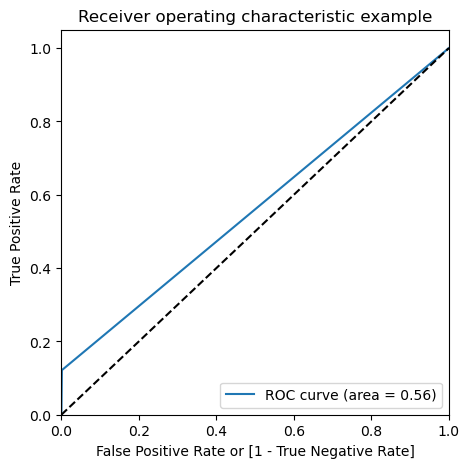

In [68]:
draw_roc(y_test,y_pred_proba)